# <font color = red> IMAGE_CAPTIONING USING TRANSFER LEARNING </font>

In [1]:
#importing libraries
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from glob import glob
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")


## <font color = red > Show the images and captions from dataset
</font>

In [2]:
#Show the datase
image_path = 'flicker/Flicker8k_Dataset/'
image_list = glob(image_path + '*.jpg')
image_list[:10]

['flicker/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'flicker/Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'flicker/Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'flicker/Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'flicker/Flicker8k_Dataset\\1007129816_e794419615.jpg',
 'flicker/Flicker8k_Dataset\\1007320043_627395c3d8.jpg',
 'flicker/Flicker8k_Dataset\\1009434119_febe49276a.jpg',
 'flicker/Flicker8k_Dataset\\1012212859_01547e3f17.jpg',
 'flicker/Flicker8k_Dataset\\1015118661_980735411b.jpg',
 'flicker/Flicker8k_Dataset\\1015584366_dfcec3c85a.jpg']

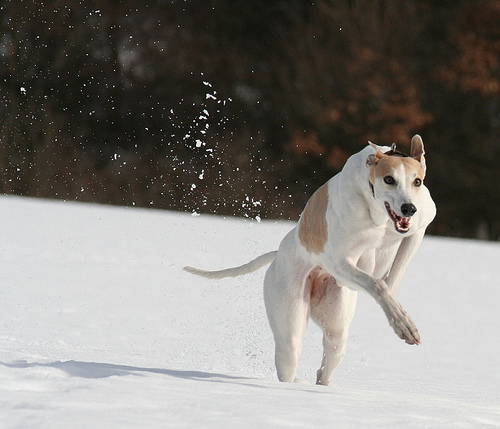

In [3]:
# image display
Image.open(image_list[10])
#load_img(image_list[555])

In [5]:
# show the caption
caption_path = 'flicker/'
caption_list = open(caption_path + 'Flickr8k.lemma.token.txt', 'rb').read().decode('utf-8').split('\n')
print(f"caption_list type : {type(caption_list)}\ncaption_list size : {len(caption_list)}")
print('\nfirst 10 captions are .....\n')
for i in range(10):
    print(caption_list[i])

caption_list type : <class 'list'>
caption_list size : 40461

first 10 captions are .....

1358089136_976e3d2e30.jpg#0	A boy sand surf down a hill
1358089136_976e3d2e30.jpg#1	A man be attempt to surf down a hill make of sand on a sunny day .
1358089136_976e3d2e30.jpg#2	A man be slide down a huge sand dune on a sunny day .
1358089136_976e3d2e30.jpg#3	A man be surf down a hill of sand .
1358089136_976e3d2e30.jpg#4	A young man in short and t-shirt be snowboard under a bright blue sky .
1362128028_8422d53dc4.jpg#0	kid play in a blue tub full of water outside
1362128028_8422d53dc4.jpg#1	On a hot day , three small kid sit in a big container fill with water .
1362128028_8422d53dc4.jpg#2	Little kid sit outdoors in a small tub of water .
1362128028_8422d53dc4.jpg#3	Three child squeeze into a plastic tub fill with water and play .
1362128028_8422d53dc4.jpg#4	Three little boy take a bath in a rubber bin on the grass .
1383698008_8ac53ed7ec.jpg#0	A man be snowboard over a structure on a snowy hill

## <font color=red>Preprocess the captions</font>
<font color = orange> 
- create a dictionary.
- key of dictionary will be the image id
- value will a list. Each list consist of 5 captions
- Each caption then convert to lower
- Remove punctuations, digit and other special characters
- Remove extra space
- Add "__sos__" and "__eos__" before and after each caption respectivly 
- Tokenizing the captions
- create vocab
- check max length of tokens and set padding according to that
  
</font>

In [6]:
# creating dictionary of image_caption_pair

caption_dict = {}
for item in caption_list:
   
    token = item.split('\t')
    if len(token)<2:
        continue
    image_id = token[0]
    caption = token[1]
    image_id = image_id.split('.')[0]

    if image_id  not in caption_dict:
        caption_dict[image_id] = []
        caption_dict[image_id].append(caption)
    else:

        caption_dict[image_id].append(caption)

len(caption_dict)

8092

In [7]:
# creating a function that clean the captions

def caption_cleaning(caption_dict):
    
    for k in caption_dict.keys():
        
        for i in enumerate(caption_dict[k]):
            
            index = i[0]
            v = i[1]
           
            #lower case
            v = v.lower()
            #remove punctuations, digits, special characters
            v = v.replace('[^A-Za-z]', '')
            v = v.replace('\s+', '')
            v = v.replace('.', '')
            # add <sos> and <eos> tag before and after the captions
            v = 'sos ' + v + ' eos'    
           
            caption_dict[k][index] = v
          
            
            
caption_cleaning(caption_dict)  


In [8]:
# get all caption in a list from dictionary
all_captions = []
for v in caption_dict.values():
    for i in v:
        all_captions.append(i)
all_captions[:10]

["sos a man in street racer armor be examine the tire of another racer 's motorbike  eos",
 'sos two racer drive a white bike down a road  eos',
 'sos two motorist be ride along on their vehicle that be oddly design and color  eos',
 'sos two person be in a small race car drive by a green hill  eos',
 'sos two person in race uniform in a street car  eos',
 'sos a firefighter extinguish a fire under the hood of a car  eos',
 'sos a fireman spray water into the hood of small white car on a jack eos',
 'sos a fireman spray inside the open hood of small white car , on a jack  eos',
 'sos a fireman use a firehose on a car engine that be up on a carjack  eos',
 'sos firefighter use water to extinguish a car that be on fire  eos']

In [9]:
## Tokenizations
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
size_of_vocab = len(tokenizer.word_index)+1
print(size_of_vocab)

6445


In [10]:
# max length of a caption
MAX_LENGTH  = 0
for v in all_captions:
    if len(v.split())>MAX_LENGTH:
        x = v.split()
    MAX_LENGTH = max(MAX_LENGTH,len(v.split()))
    
print(MAX_LENGTH,x)
    

39 ['sos', 'an', 'african-american', 'man', 'wear', 'a', 'green', 'sweatshirt', 'and', 'blue', 'vest', 'be', 'hold', 'up', '2', 'dollar', 'bill', 'in', 'front', 'of', 'his', 'face', ',', 'while', 'stand', 'on', 'a', 'busy', 'sidewalk', 'in', 'front', 'of', 'a', 'group', 'of', 'man', 'play', 'instrument', 'eos']


## <font color = red> Load pretrained VGG16 model</font>

In [10]:
#load vgg16 model for transfer learning

model = VGG16()
# modify model. Exclude last 2 layers
model = Model(inputs = model.inputs,outputs = model.layers[-2].output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## <font color = red> Extract all the image's features using VGG16 model </font>

In [11]:
# feature extraction function

def feature_extraction(image_list):
    
    # extract features from image
    features_dict = {}
    count = len(image_list)
    
    for i in tqdm(range(count)):
        # load and resize the image as vgg takes 224,224 pixels image
        image= load_img(image_list[i], target_size = (224,224))
        #convert to numpy array it will be (2224,224,3)
        image = img_to_array(image)

        #reshape the image array, here 1 is used to indicate 1 instance
        image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
        #preprocess the input for VGG
        image = preprocess_input(image)
        # extract features, verbose = 0 to hide any warnings 
        feature = model.predict(image, verbose=0)

        #get the image_id
        #remove .jpeg
        try:
            image_id = image_list[i].split(".")[0]
            #remove file directory name
            image_id = image_id.split("\\")[1]
        except:
            pass

        features_dict[image_id] = feature
    return features_dict



In [16]:
# call feature extraction function
features_dict = feature_extraction(image_list)

  0%|          | 0/67 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## <font color = red> Train test split</font>

In [ ]:
# Train test split
split = int(len(image_list) * 0.0095)
train = image_list[:split]
test = image_list[split:]
print(len(train), len(test))

## <font color = red> Generate tarning data set
- Data has 2 features and a output.
- For a perticular image ->
    - X is the feature of that image get by the VGG16 model 
    - all the caption of the image will be feeded in sequence
    - for example: caption= "this is a dog"
    - this will be feeded as followes
    </font>
    <font color = green>
    - sos + X --> this
    - sos + this + X -->  is 
    - sos + this + is +X --> a
    - sos + this + is + X --> dog
    - sos + this + is + a + X --> eos
</font>

In [17]:
#generate traning set
def generator(train,features_dict,caption_dict):
    X = []
    y_in = []
    y_out = []
    
#     for caption in caption_dict.values():
#                 # encode the sequence
#                 seq = tokenizer.texts_to_sequences([caption])[0]

    for item in tqdm(train): 
        
         #remove .jpeg
        item = item.split(".")[0]
        #remove file directory name
        item = item.split("\\")[1]
        caption_list = caption_dict[item]
        
        
        for single_caption in caption_list:              
            # embedding the caption
            single_caption = tokenizer.texts_to_sequences([single_caption])[0]
            
            for i in range(1,len(single_caption)):
                
                X.append(features_dict[item])             
                in_seq = [single_caption[:i]]
                out_seq = single_caption[i]
                
                in_seq = pad_sequences(in_seq,maxlen = MAX_LENGTH)[0]
                out_seq = to_categorical([out_seq],num_classes= size_of_vocab)[0]
                y_in.append(in_seq)
                y_out.append(out_seq)
    return X,y_in,y_out            
    

In [ ]:
# call the function to generate
X, y_in, y_out = tqdm(generator(train,features_dict, caption_dict))

In [ ]:
# conver all the list to numpy array
train_values=[]
for i in X:
    train_values.append(X[0][0])
    
X=np.array(train_values)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')


## <font color= red> Model Create </font>

### <font color = green> Encoder creatation </font>

In [20]:
#image feature layer
input1 = Input(shape=(4096,))   # 4096 is the output size of VGG16
feature1 = Dropout(0.4)(input1)
feature2 = Dense(256, activation = "relu")(feature1)

#caption feature sequence layer
input2 = Input(shape=(MAX_LENGTH,))
sequence1 =  Embedding(size_of_vocab,256,mask_zero = True)(input2)
sequence2 = Dropout(0.4)(sequence1)
seuqence3 = LSTM(256)(sequence2)


### <font color= green>Decoder creatation </font>

In [21]:
#decoder
decoder1 = add([feature2,seuqence3])
decoder2 = Dense(256, activation = "relu")(decoder1)
outputs = Dense(size_of_vocab, activation = "softmax")(decoder2)


In [22]:
model = Model(inputs = [input1,input2], outputs = outputs)
model.compile(loss='categorical_crossentropy',optimizer = 'adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 39)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 39, 256)      1649920     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

## <font color = red> Fit the model </font>

In [25]:
history = model.fit([X, y_in], y_out,validation_split=0.05, batch_size=100, epochs=5).history


Epoch 1/5
40/40 [==============================] - ETA: 0s - loss: 5.1167 - accuracy: 0.1732WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002046D83AF78> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
40/40 [==============================] - 16s 393ms/step - loss: 5.1167 - accuracy: 0.1732 - val_loss: 5.4591 - val_accuracy: 0.1505
E

## <font color= red> Model Save </font>

In [26]:
import pickle
model.save('caption_to_image.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('caption_to_image.h5')
history = pickle.load(open("history.p", "rb"))

## <font color = red> Plot accuracy of traning and validation set</font>

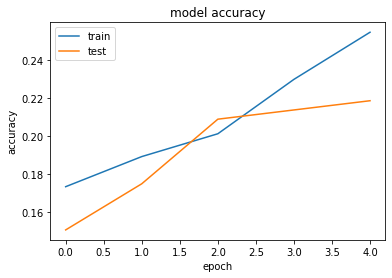

In [27]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## <font color = red> Plot loss of validation vs training set </font>

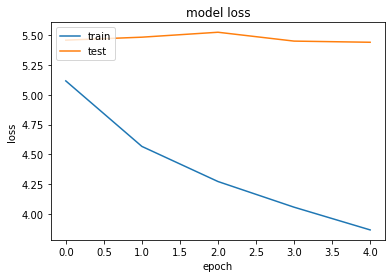

In [28]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [29]:

import pickle
model = load_model('caption_to_image.h5')
#tokenizer = pickle.load(open('tokenizer.pkl','rb'))
# Predict Image caption
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [13]:


# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    
    
    
    
    # Get user input image
#     user_image_list = [] 
#     from IPython.display import Image
#     image_l.append(Image("hill.jpg"))
#     image = feature_extraction(image_l)
#     image = image
    
    
    
    # add start tag for generation process
    in_text = 'sos'
    
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        
        # predict next word
        y_pred = model.predict([image, sequence], verbose=0)
        # get index with high probability
        y_pred = np.argmax(y_pred)
        # convert index to word
        word = idx_to_word(y_pred, tokenizer)
        # stop if word not found
        
        if word is None:
            break
            
        # stop if we reach end tag
        if word == 'eos':
            break
           
        # append word as input for generating next word
        else:
            in_text += " " + word
        
      
    return in_text

In [4]:
y_pred = predict_caption(model, features_dict['1015584366_dfcec3c85a'], tokenizer, MAX_LENGTH)
y_pred =  y_pred.split(" ")[1:]
caption = ""
for c in y_pred:
    caption +=" "+ c

print("Predicted Caption is ---> a black dog tree")

Predicted Caption is ---> a black dog tree


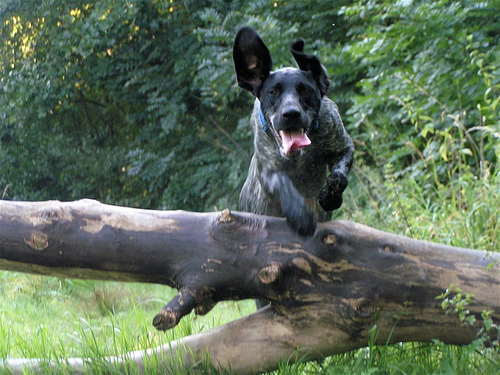

In [46]:
Image.open('flicker/Flicker8k_Dataset\\1015584366_dfcec3c85a.jpg')

In [104]:
caption_dict['1015584366_dfcec3c85a']

['sos a black dog leap over a log  eos',
 'sos a gray dog be leap over a fall tree  eos',
 'sos a large black dog leap a fallen log  eos',
 'sos a mottled black and gray dog in a blue collar jump over a fall tree  eos',
 'sos a black dog jump a tree stump  eos']